In [1]:
sc

<SparkContext master=local[*] appName=PySparkShell>

In [2]:
import re
import numpy as np
from pyspark.mllib.linalg import SparseVector
from pyspark.mllib.regression import LabeledPoint
import pandas as pd
import matplotlib.pyplot as plt
from numpy.linalg import norm

## Task 1 : Data Preparation

In [3]:
def freqArray (listOfIndices, numberofwords):
    returnVal = np.zeros (20000)
    for index in listOfIndices:
        returnVal[index] = returnVal[index] + 1
    returnVal = np.divide(returnVal, numberofwords)
    return returnVal

In [4]:
d_corpus = sc.textFile("/Users/pudding/Downloads/SmallTrainingData.txt", 1)

In [5]:
# Now, we transform it into a set of (docID, text) pairs
d_keyAndText = d_corpus.map(lambda x : (x[x.index('id="') + 4 : x.index('" url=')], x[x.index('">') + 2:][:-6]))

In [6]:
# remove all non letter characters
regex = re.compile('[^a-zA-Z]')
d_keyAndListOfWords = d_keyAndText.map(lambda x : (str(x[0]), regex.sub(' ', x[1]).lower().split()))

In [7]:
# change (docID, ["word1", "word2", "word3", ...]) to ("word1", 1) ("word2", 1)
allWords = d_keyAndListOfWords.flatMap(lambda x: x[1]).map(lambda x: (x, 1))
allWords.take(2)

[('consideration', 1), ('of', 1)]

In [8]:
# Now, count all of the words, giving us ("word1", 1433), ("word2", 3423423), etc.
allCounts = allWords.reduceByKey(lambda x,y: x+y)

In [9]:
# Get the top 20,000 words in a local array in a sorted format based on frequency
# If you want to run it on your laptio, it may a longer time for top 20k words. 
topWords = allCounts.top(20000, key=lambda x: x[1])

In [10]:
topWords[:5]

[('the', 447995),
 ('of', 205873),
 ('and', 177099),
 ('in', 158991),
 ('to', 144197)]

In [11]:
topWords[-5:]

[('fiqh', 17),
 ('sirte', 17),
 ('chittagong', 17),
 ('odisha', 17),
 ('morelos', 17)]

In [12]:
# We'll create a RDD that has a set of (word, dictNum) pairs
# start by creating an RDD that has the number 0 through 20000
# 20000 is the number of words that will be in our dictionary
topWordsK = sc.parallelize(range(20000))

In [13]:
# Now, we transform (0), (1), (2), ... to ("MostCommonWord", 1)
# ("NextMostCommon", 2), ...
# the number will be the spot in the dictionary used to tell us
# where the word is located
dictionary = topWordsK.map (lambda x : (topWords[x][0], x))

print("Word Postions in our Feature Matrix. Last 20 words in 20k positions: ", dictionary.top(20, lambda x : x[1]))

Word Postions in our Feature Matrix. Last 20 words in 20k positions:  [('morelos', 19999), ('odisha', 19998), ('chittagong', 19997), ('sirte', 19996), ('fiqh', 19995), ('sajjada', 19994), ('cra', 19993), ('restarted', 19992), ('severus', 19991), ('ngan', 19990), ('magnolia', 19989), ('hornets', 19988), ('symmetric', 19987), ('abolitionist', 19986), ('payoff', 19985), ('lehmann', 19984), ('qasim', 19983), ('dreyer', 19982), ('harkleroad', 19981), ('cain', 19980)]


In [14]:
freq_lookup_words = ['applicant', 'and', 'attack', 'protein', 'car']
for w in freq_lookup_words:
    result = dictionary.filter(lambda x: w in x).collect()
    if len(result) == 0:
        print("The word '%s' does not appear in the dictionary, so the frequency position of the word is -1." % w)
    else:
        print("The frequency position of the word '%s' is %d." % (w, result[0][1]))

The frequency position of the word 'applicant' is 346.
The frequency position of the word 'and' is 2.
The frequency position of the word 'attack' is 502.
The frequency position of the word 'protein' is 3014.
The frequency position of the word 'car' is 608.


## Task 2: Learning the Model

In [15]:
# Next, we get a RDD that has, for each (docID, ["word1", "word2", "word3", ...]),
# ("word1", docID), ("word2", docId), ...

allWordsWithDocID = d_keyAndListOfWords.flatMap(lambda x: ((j, x[0]) for j in x[1]))

In [16]:
# Now join and link them, to get a set of ("word1", (dictionaryPos, docID)) pairs
allDictionaryWords = dictionary.join(allWordsWithDocID)

In [17]:
# Now, we drop the actual word itself to get a set of (docID, dictionaryPos) pairs
justDocAndPos = allDictionaryWords.map(lambda x: (x[1][1],x[1][0]))
justDocAndPos.take(3)

[('AU35', 1), ('AU35', 1), ('AU35', 1)]

In [18]:
# Now get a set of (docID, [dictionaryPos1, dictionaryPos2, dictionaryPos3...]) pairs
allDictionaryWordsInEachDoc = justDocAndPos.groupByKey()

In [19]:
def buildArray(listOfIndices):
    
    returnVal = np.zeros(20000)
    
    for index in listOfIndices:
        returnVal[index] = returnVal[index] + 1
    
    mysum = np.sum(returnVal)
    
    returnVal = np.divide(returnVal, mysum)
    
    return returnVal

In [20]:
# function to convert regular array to SparseVector
def convert_array_to_sparse(my_array):
    index = [i for i, e in enumerate(my_array) if e != 0]
    value = [e for i, e in enumerate(my_array) if e != 0]
    size = len(my_array)
    my_sparse_vector = SparseVector(size, index, value)
    return my_sparse_vector

In [21]:
# The following line this gets us a set of
# (docID,  [dictionaryPos1, dictionaryPos2, dictionaryPos3...]) pairs
# and converts the dictionary positions to a bag-of-words numpy array...

# sparse version
#allDocsAsNumpyArrays = allDictionaryWordsInEachDoc.map(lambda x: LabeledPoint(x[0].startswith("AU")*1,\
#                                                                 convert_array_to_sparse(buildArray(x[1]))))

# dense version
allDocsAsNumpyArrays = allDictionaryWordsInEachDoc.map(lambda x: (x[0].startswith("AU")*1,buildArray(x[1])))


### Logistic Regression without regularization

In [23]:
myRDD = allDocsAsNumpyArrays

In [22]:
# Now we do gradient Decent on our RDD data set. 

learningRate = 150
num_iteration = 100
maxIteration = 400

precision = 0.01
lamb = 0

beta = np.zeros(20000)
oldCost = 0

## convert beta to sparse beta for sparse vector dot product
#beta_len = len(beta)
#beta_index = list(range(len(beta)))
#sparse_beta = SparseVector(beta_len, beta_index, beta)

In [24]:
size = myRDD.count()

In [25]:
initCost = myRDD.map(lambda x: (x[0], x[1], np.dot(x[1], beta)))\
                .map(lambda x: (x[1]*(-x[0]+(np.exp(x[2])/(1+np.exp(x[2])))), \
                                -x[0]*x[2]+np.log(1+np.exp(x[2]))))\
                .reduce(lambda x, y: (x[0]+y[0], x[1]+y[1]))

In [26]:
#initCost = myRDD.map(lambda x: (x.label, x.features, x.features.dot(sparse_beta)))\
#                .map(lambda x: (x[1]*(-x[0]+(np.exp(x[2])/(1+np.exp(x[2])))), \
#                                -x[0]*x[2]+np.log(1+np.exp(x[2]))))\
#                .reduce(lambda x, y: (x[0]+y[0], x[1]+y[1]))

0 Beta [0. 0. 0. ... 0. 0. 0.]  Cost 2385.812595487337
1 Beta [-5.62052152e+00 -2.62399112e+00 -2.38145596e+00 ... -5.12598884e-04
 -4.19910267e-04 -2.11420316e-04]  Cost 1301.7109596357272
2 Beta [-8.79142465e+00 -4.10864262e+00 -3.78423993e+00 ... -8.40945617e-04
 -6.65994427e-04 -3.23545629e-04]  Cost 926.5224584174243
3 Beta [-1.08788523e+01 -5.08848711e+00 -4.74660007e+00 ... -1.08185224e-03
 -8.36955886e-04 -3.94588253e-04]  Cost 752.2549348757707
4 Beta [-1.24034520e+01 -5.80563251e+00 -5.47656983e+00 ... -1.27438329e-03
 -9.69221204e-04 -4.45646586e-04]  Cost 654.494562324634
5 Beta [-1.35884552e+01 -6.36403285e+00 -6.06463776e+00 ... -1.43631460e-03
 -1.07812039e-03 -4.85269178e-04]  Cost 593.0292017025096
6 Beta [-1.45473485e+01 -6.81660411e+00 -6.55733747e+00 ... -1.57712019e-03
 -1.17139515e-03 -5.17597697e-04]  Cost 551.3761069254648
7 Beta [-1.53452412e+01 -7.19373917e+00 -6.98161384e+00 ... -1.70244382e-03
 -1.25348319e-03 -5.44914196e-04]  Cost 521.6170761455596
8 Beta 

62 Beta [-2.18621916e+01 -1.03522319e+01 -1.39906635e+01 ... -4.64294377e-03
 -3.08444025e-03 -1.01927071e-03]  Cost 384.1465691489094
63 Beta [-2.18511872e+01 -1.03483273e+01 -1.40592010e+01 ... -4.68119215e-03
 -3.10790610e-03 -1.02481085e-03]  Cost 383.779551927851
64 Beta [-2.18392343e+01 -1.03439662e+01 -1.41272599e+01 ... -4.71930601e-03
 -3.13128996e-03 -1.03033350e-03]  Cost 383.4149312141742
65 Beta [-2.18263785e+01 -1.03391700e+01 -1.41948605e+01 ... -4.75729067e-03
 -3.15459523e-03 -1.03583968e-03]  Cost 383.0525293907027
66 Beta [-2.18126631e+01 -1.03339593e+01 -1.42620224e+01 ... -4.79515116e-03
 -3.17782515e-03 -1.04133038e-03]  Cost 382.6921848906399
67 Beta [-2.17981289e+01 -1.03283535e+01 -1.43287637e+01 ... -4.83289228e-03
 -3.20098279e-03 -1.04680653e-03]  Cost 382.33375065932273
68 Beta [-2.17828151e+01 -1.03223709e+01 -1.43951021e+01 ... -4.87051856e-03
 -3.22407107e-03 -1.05226901e-03]  Cost 381.9770927741512
69 Beta [-2.17667585e+01 -1.03160290e+01 -1.44610539e+0

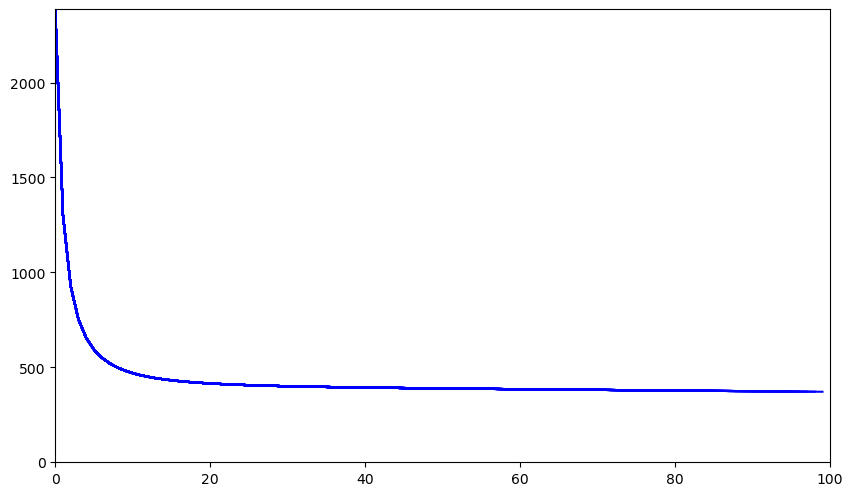

In [27]:
# two variables for visualizing the cost
xx, costHist = [], [] 

fig = plt.figure(figsize=(10,6), dpi= 100, facecolor='w', edgecolor='k')
ax2 = plt.subplot(1, 1, 1)
ax2.set_xlim(left = 0, right=num_iteration)
ax2.set_ylim(bottom = 0, top=initCost[1])

# Let's start with main iterative part of gradient descent algorithm 
for i in range(num_iteration):

    gradientCost = myRDD.map(lambda x: (x[0], x[1], np.dot(x[1], beta)))\
                        .map(lambda x: (-x[1]*x[0]+x[1]*(np.exp(x[2])/(1+np.exp(x[2]))), \
                                        -x[0]*x[2]+np.log(1+np.exp(x[2]))))\
                        .reduce(lambda x, y: (x[0]+y[0], x[1]+y[1]))
    
    cost = gradientCost[1] + lamb*(norm(beta)**2)
    
    gradient = (1/float(size)) * (gradientCost[0] + 2*lamb*beta)
    
    # Stop if the cost is not descreasing 
    if(abs(cost - oldCost) <= precision):
        print("Stopped at iteration", i)
        break
        
    if(i >= maxIteration):
        print("Reach maximum iteration allowed, stopped at iteration", maxIteration)
        break

    oldCost = cost
    
    # Visualization     
    # Update the Cost Diagram. 
    xx.append(i)
    costHist.append(cost)    
    ax2.plot(xx, costHist, color='blue')

    fig.canvas.draw()
    
    print(i, "Beta", beta, " Cost", cost)
    beta = beta - learningRate * gradient

In [71]:
# the top 5 words with the largest regression coefficients (in descending order)
top5_beta = np.sort(beta)[::-1][:5]
top5_beta_index = [np.where(beta == x)[0][0] for x in top5_beta]
[dictionary.filter(lambda x: y in x).collect()[0] for y in top5_beta_index]

[('morelos', 19999),
 ('odisha', 19998),
 ('chittagong', 19997),
 ('sirte', 19996),
 ('fiqh', 19995)]

In [129]:
for i in range(5):
    w = top5_beta_index[i]
    w_tuple = dictionary.filter(lambda x: w in x).collect()[0]
    print("top %d word with large coefficient is %s" % (i+1, w_tuple[0]))    

top 1 word with large coefficient is morelos
top 2 word with large coefficient is odisha
top 3 word with large coefficient is chittagong
top 4 word with large coefficient is sirte
top 5 word with large coefficient is fiqh


In [107]:
accuracy = myRDD.map(lambda x: (x[0], np.dot(x[1], beta)))\
                               .map(lambda x: (x[0], np.exp(x[1])/(1+np.exp(x[1]))))\
                               .map(lambda x: (x[1] > 0.5)*1 == x[0]).mean()
accuracy

0.9785008715862871

### Logistic Regression with regularization

In [117]:
def LogisticRegularization(myRDD, my_lambda,\
                           learningRate = 150,\
                           num_iteration = 100,\
                           maxIteration = 400,\
                           precision = 0.01):

    size = myRDD.count()
    beta = np.zeros(20000)
    oldCost = 0
    
    # Let's start with main iterative part of gradient descent algorithm 
    for i in range(num_iteration):

        gradientCost = myRDD.map(lambda x: (x[0], x[1], np.dot(x[1], beta)))\
                            .map(lambda x: (-x[1]*x[0]+x[1]*(np.exp(x[2])/(1+np.exp(x[2]))), \
                                            -x[0]*x[2]+np.log(1+np.exp(x[2]))))\
                            .reduce(lambda x, y: (x[0]+y[0], x[1]+y[1]))

        cost = gradientCost[1] + my_lambda*(norm(beta)**2)

        gradient = (1/float(size)) * (gradientCost[0] + 2*my_lambda*beta)

        # Stop if the cost is not descreasing 
        if(abs(cost - oldCost) <= precision):
            print("Stopped at iteration", i)
            break

        if(i >= maxIteration):
            print("Reach maximum iteration allowed, stopped at iteration", maxIteration)
            break

        oldCost = cost
        beta = beta - learningRate * gradient
        
    accuracy = myRDD.map(lambda x: (x[0], np.dot(x[1], beta)))\
                               .map(lambda x: (x[0], np.exp(x[1])/(1+np.exp(x[1]))))\
                               .map(lambda x: (x[1] > 0.5)*1 == x[0]).mean()
    return accuracy, beta

In [124]:
# run on a set of lambdas
lambda_candidates = [0, 2, 4, 6, 8, 10]
accuracy_list = []
beta_list = []
for x in lambda_candidates:
    current_accuracy, current_beta = LogisticRegularization(myRDD, x)
    accuracy_list.append(current_accuracy)
    beta_list.append(current_beta)
    
    # the top 5 words with the largest regression coefficients (in descending order)
    top5_current_beta = np.sort(current_beta)[::-1][:5]
    top5_current_beta_index = [np.where(current_beta == x)[0][0] for x in top5_best_beta]
    
    print("Current testing lambda is %.2lf with accuracy %.4lf, the top 5 words are given below." % (x, current_accuracy))
    for i in range(5):
        w = top5_current_beta_index[i]
        w_tuple = dictionary.filter(lambda x: w in x).collect()[0]
        print("top %d word with large coefficient is %s" % (i+1, w_tuple[0]))    

# select the best lambda yield the highest accuracy
best_accuracy_index = accuracy_list.index(max(accuracy_list))
best_beta = beta_list[best_accuracy_index]

Stopped at iteration 12
Stopped at iteration 6


In [132]:
print("The best regularization value is %.2lf with accuracy %.4lf." % \
      (lambda_candidates[best_accuracy_index], \
       accuracy_list[best_accuracy_index]))

The best regularization value is 2.00 with accuracy 0.9785.


In [130]:
# the top 5 words with the largest regression coefficients (in descending order)
top5_best_beta = np.sort(best_beta)[::-1][:5]
top5_best_beta_index = [np.where(best_beta == x)[0][0] for x in top5_best_beta]

for i in range(5):
    w = top5_best_beta_index[i]
    w_tuple = dictionary.filter(lambda x: w in x).collect()[0]
    print("top %d word with large coefficient is %s" % (i+1, w_tuple[0]))    

top 1 word with large coefficient is applicant
top 2 word with large coefficient is tribunal
top 3 word with large coefficient is mr
top 4 word with large coefficient is respondent
top 5 word with large coefficient is application


## Task 3 - Evaluation of the learned Model

In [150]:
d_test_corpus = sc.textFile("/Users/pudding/Downloads/TestingData.txt", 1)

In [151]:
# Now, we transform it into a set of (docID, text) pairs
d_test_keyAndText = d_test_corpus.map(lambda x : (x[x.index('id="') + 4 : x.index('" url=')], x[x.index('">') + 2:][:-6]))

In [152]:
# remove all non letter characters
regex = re.compile('[^a-zA-Z]')
d_test_keyAndListOfWords = d_test_keyAndText.map(lambda x : (str(x[0]), regex.sub(' ', x[1]).lower().split()))

In [155]:
# Next, we get a RDD that has, for each (docID, ["word1", "word2", "word3", ...]),
# ("word1", docID), ("word2", docId), ...

test_allWordsWithDocID = d_test_keyAndListOfWords.flatMap(lambda x: ((j, x[0]) for j in x[1]))

In [156]:
# Now join and link them, to get a set of ("word1", (dictionaryPos, docID)) pairs
test_allDictionaryWords = dictionary.join(test_allWordsWithDocID)

In [180]:
test_allDictionaryWords.take(1)

[('was', (6, 'AU11'))]

In [159]:
# Now, we drop the actual word itself to get a set of (docID, dictionaryPos) pairs
test_justDocAndPos = test_allDictionaryWords.map(lambda x: (x[1][1],x[1][0]))
test_justDocAndPos.take(3)

[('AU11', 6), ('AU11', 6), ('AU11', 6)]

In [160]:
# Now get a set of (docID, [dictionaryPos1, dictionaryPos2, dictionaryPos3...]) pairs
test_allDictionaryWordsInEachDoc = test_justDocAndPos.groupByKey()

In [161]:
# The following line this gets us a set of
# (docID,  [dictionaryPos1, dictionaryPos2, dictionaryPos3...]) pairs
# and converts the dictionary positions to a bag-of-words numpy array...

# dense version
test_allDocsAsNumpyArrays = test_allDictionaryWordsInEachDoc.map(lambda x: (x[0].startswith("AU")*1,buildArray(x[1])))

In [165]:
test_myRDD = test_allDocsAsNumpyArrays

In [193]:
y_true = test_myRDD.keys().collect()

In [194]:
y_true = np.array(y_true)

In [195]:
y_pred = test_myRDD.map(lambda x: np.dot(x[1], best_beta)).map(lambda x: ((np.exp(x)/(1+np.exp(x)))>1)*1).collect()

In [196]:
y_pred = np.array(y_pred)

In [209]:
TP = np.sum((y_true == 1) & (y_pred == 1))
TN = np.sum((y_true == 0) & (y_pred == 0))
FP = np.sum((y_true == 0) & (y_pred == 1))
FN = np.sum((y_true == 1) & (y_pred == 0))
f1_score = (2*TP)/(2*TP+FP+FN)

In [212]:
print("The true positive is %d." % TP)
print("The true negative is %d." % TN)
print("The false positive is %d." % FP)
print("The false negative is %d." % FN)
print("The F1 score is %.4lf." % f1_score)

The true positive is 0.
The true negative is 18347.
The false positive is 0.
The false negative is 377.
The F1 score is 0.0000.


In [278]:
if FP == 0:
    print("There is no False Positive case.")
elif FP == 1:
    article_index = np.where((y_true == 0) & (y_pred == 1))[0][0]
    print(d_test_keyAndText.take(article_index+1)[article_index])
elif FP == 2:
    article_index = np.where((y_true == 0) & (y_pred == 1))[0][0]
    print(d_test_keyAndText.take(article_index+1)[article_index])   
    article_index = np.where((y_true == 0) & (y_pred == 1))[0][1]
    print(d_test_keyAndText.take(article_index+1)[article_index])
else: 
    article_index = np.where((y_true == 0) & (y_pred == 1))[0][0]
    print(d_test_keyAndText.take(article_index+1)[article_index])   
    article_index = np.where((y_true == 0) & (y_pred == 1))[0][1]
    print(d_test_keyAndText.take(article_index+1)[article_index])  
    article_index = np.where((y_true == 0) & (y_pred == 1))[0][2]
    print(d_test_keyAndText.take(article_index+1)[article_index])      

('AU1174', "bailpending appeal from court of summary jurisdictionwhere appellant has been sentenced to imprisonment for offences under the copyright act 1968 whether the court has jurisdiction to stay or suspend the operation of the sentence pending the hearing of an appeal against the sentenceappealI was approached urgently tonight in this appeal to grant bail to the appellant pending an opportunity for a hearing on whether or not he should be granted bail or the orders for his weekend detention should be stayed.The application has been made ex parte in circumstances where, because of the lateness of the hour, I have conducted the hearing by telephone with the solicitor for the appellant being present on the telephone together with the appellant personally.I am satisfied that I have jurisdiction to make orders as a single judge exercising the appellate jurisdiction pursuant to s 25 of the Federal Court of Australia Act 1976  .For present purposes, and in the absence of any detailed ar